# **Sujet : Reconnaissance de caractères**
<p>Développer un code pour détecter des caractères.<p>

<br>https://francescopochetti.com/text-recognition-natural-scenes/

In [ ]:
import os
from google.colab import drive
drive.mount('drive')
!mkdir -p drive -v
cwd = os.getcwd()

Mounted at drive


In [ ]:
import math
import matplotlib.pyplot
import numpy
import skimage
import scipy
import sklearn
import glob
import cv2
import tensorflow
import joblib

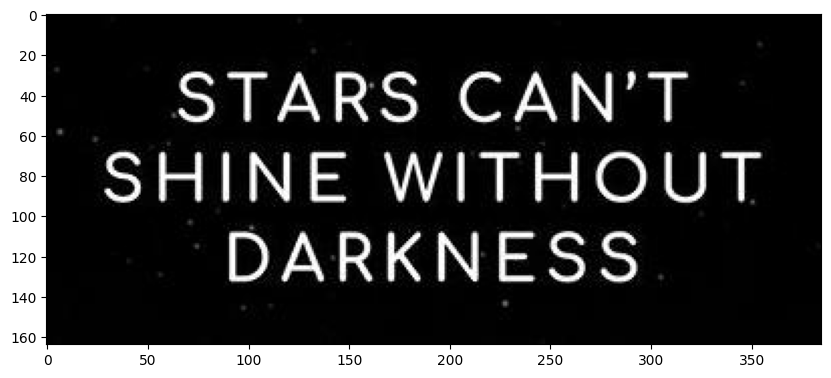

In [ ]:
from skimage.io import imread
from matplotlib.pyplot import figure, imshow

img_gray = imread('drive/My Drive/Colab Notebooks/image01.jpg', as_gray=True) # lecture de l'image
img_rgb = imread('drive/My Drive/Colab Notebooks/image01.jpg', as_gray=False) # lecture de l'image

img_height, img_width = img_gray.shape
figure(figsize=(10, 10)) # visualisation
imshow(img_gray, cmap='gray') # visualisation de l'image image.jpg

1. **Denoising** : <br>This is done applying a <a href="https://en.wikipedia.org/wiki/Total_variation_denoising">**total variation approach**</a> which consists in reducing as much as possible the integral of the absolute gradient of the image, where the gradient of an image can simply be interpreted as a directional change in the intensity or color in the image itself.
<br>http://gael-varoquaux.info/scipy-lecture-notes/advanced/image_processing/auto_examples/plot_face_tv_denoise.html

<ipython-input-4-e4ed7e8c3c47>:4: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_tvDenoised = denoise_tv_chambolle(img_gray, weight=0.2, multichannel=True) # Using total variation filter denoising


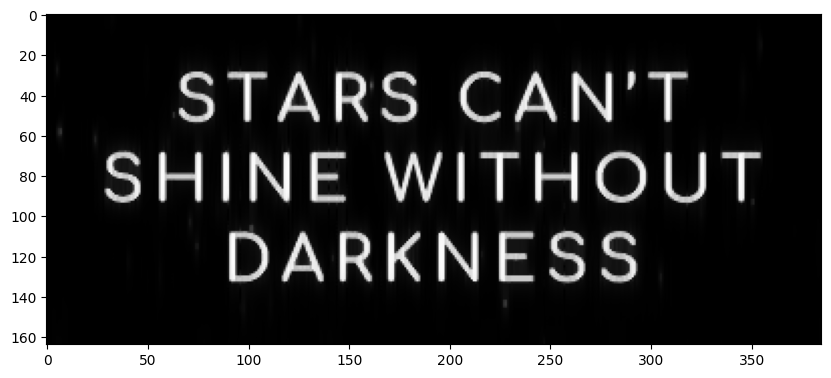

In [ ]:
from skimage.restoration import denoise_tv_chambolle
from matplotlib.pyplot import figure, imshow

img_tvDenoised = denoise_tv_chambolle(img_gray, weight=0.2, multichannel=True) # Using total variation filter denoising
figure(figsize=(10, 10)) # visualisation
imshow(img_tvDenoised, cmap='gray') # visualisation de l'image img_tvDenoised.png

2. **Increasing Contrast** : <br>This is done applying <a href="https://en.wikipedia.org/wiki/Otsu%27s_method">**Otsu‘s method**</a> which calculates an “optimal” threshold by maximizing the variance between two classes of pixels,  separated by the threshold. Equivalently, this threshold minimizes the intra-class variance.
<br>https://www.meccanismocomplesso.org/en/opencv-python-the-otsus-binarization-for-thresholding/
<br>https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html

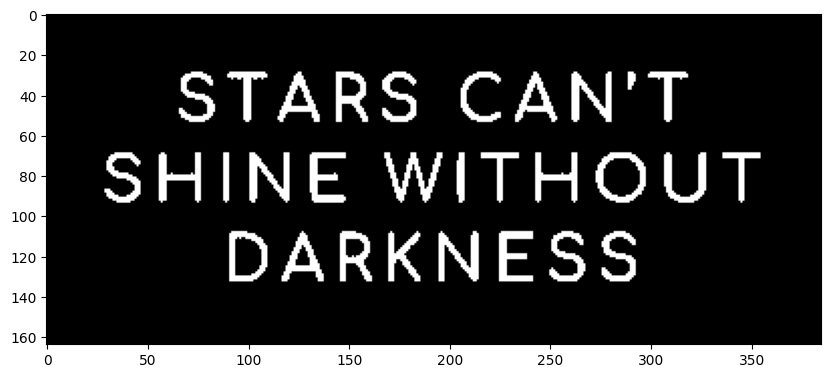

In [ ]:
from skimage.filters import threshold_otsu
from matplotlib.pyplot import figure, imshow

thresh = threshold_otsu(img_tvDenoised)
img_binary = img_tvDenoised > thresh

figure(figsize=(10, 10)) # visualisation
imshow(img_binary, cmap='gray')

3. **Object Detection** : Contours are identified and a rectangle is drawn around objects candidates.
<br>https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html
<br>https://scikit-image.org/docs/0.8.0/api/skimage.measure.find_contours.html
<br>https://muthu.co/draw-bounding-box-around-contours-skimage/

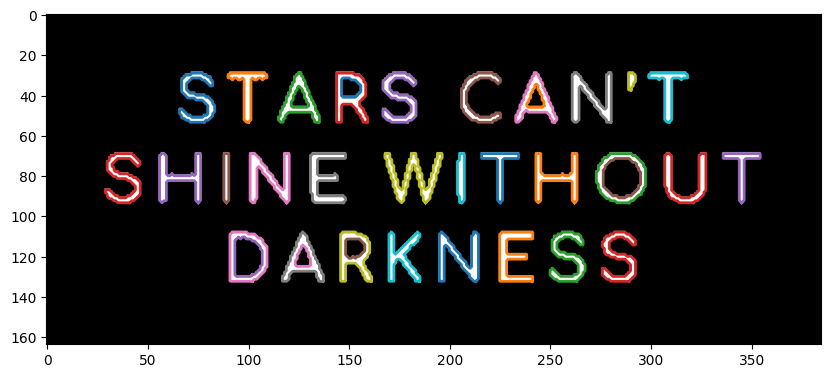

In [ ]:
from skimage.measure import find_contours
from matplotlib.pyplot import figure, plot, imshow

# Find contours at a constant value of 0.8
contours = find_contours(img_binary, level=0.8)

# Display the image and plot all contours found
figure(figsize=(10, 10)) # visualisation

for contour in contours:
  plot(contour[:, 1], contour[:, 0], linewidth=2)

imshow(img_binary, cmap='gray')
# matplotlib.pyplot.gca().invert_yaxis()

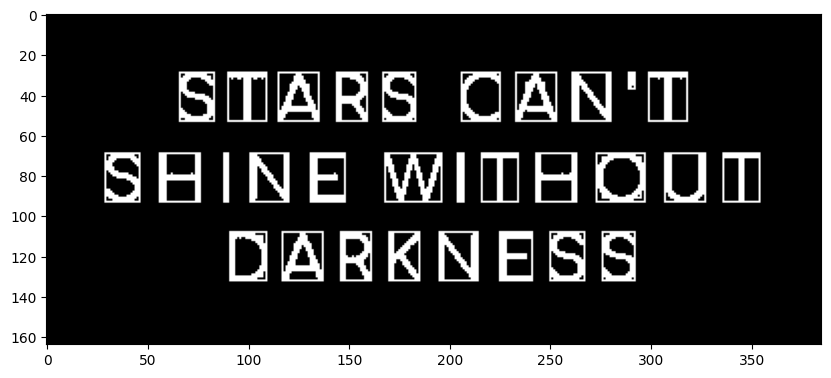

In [ ]:
from numpy import copy, min, max
from skimage.draw import polygon_perimeter
from matplotlib.pyplot import figure, imshow
# from skimage.util import invert

bounding_boxes = []
img_with_boxes = copy(img_binary)

for contour in contours:
  Xmin = min(contour[:, 0])
  Xmax = max(contour[:, 0])
  Ymin = min(contour[:, 1])
  Ymax = max(contour[:, 1])
  
  bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
  # print([int(Xmin), int(Xmax), int(Ymin), int(Ymax)])

for box in bounding_boxes:
  # [Xmin, Xmax, Ymin, Ymax]
  r = [box[0], box[1], box[1], box[0], box[0]]
  c = [box[3], box[3], box[2], box[2], box[3]]
  
  rr, cc = polygon_perimeter(r, c, img_with_boxes.shape)
  img_with_boxes[rr, cc] = 1 # set color white

# with_boxes = invert(with_boxes)

figure(figsize=(10, 10)) # visualisation
imshow(img_with_boxes, cmap="gray")

In [ ]:
# delete one bounding box that are smaller than another bounding box
bounding_boxes_new = bounding_boxes.copy()

for box_i in bounding_boxes:
  i_Xmin = box_i[0]
  i_Xmax = box_i[1]
  i_Ymin = box_i[2]
  i_Ymax = box_i[3]

  for box_j in bounding_boxes:
    j_Xmin = box_j[0]
    j_Xmax = box_j[1]
    j_Ymin = box_j[2]
    j_Ymax = box_j[3]

    if (j_Xmin > i_Xmin) and (j_Xmax < i_Xmax) and (j_Ymin > i_Ymin) and (j_Ymax < i_Ymax):
      bounding_boxes_new.remove([j_Xmin, j_Xmax, j_Ymin, j_Ymax])

print('Before : ', len(bounding_boxes), 'After : ', len(bounding_boxes_new))

Before :  37 After :  30


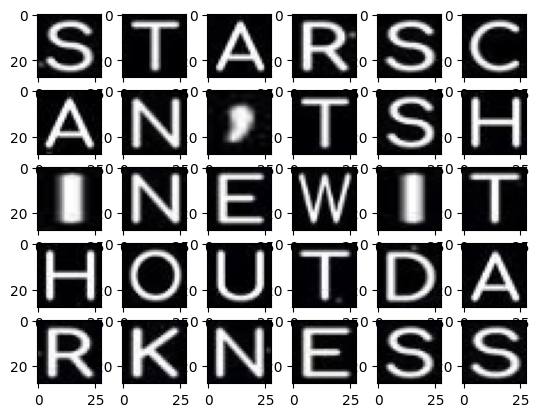

In [ ]:
from numpy import zeros
from math import ceil, floor
from skimage.transform import resize

img_num = len(bounding_boxes_new)

ROWS = 28 # 18
COLS = 28 # 12

fig = matplotlib.pyplot.figure()
img_list_resize = zeros(shape=(img_num, ROWS, COLS, 3))

for box in range(img_num):
  # nb_subplot = ceil(math.sqrt(len(bounding_boxes))) # if we have 38 images, we output 7*7 subplot
  # ax = fig.add_subplot(nb_subplot, nb_subplot, box+1)

  nb_subplot = ceil(img_num/6)
  ax = fig.add_subplot(nb_subplot, 6, box+1)

  # bias_width = 36 - (ceil(bounding_boxes[box][1]) - floor(bounding_boxes[box][0]))
  # bias_heigh = 24 - (ceil(bounding_boxes[box][3]) - floor(bounding_boxes[box][2]))
  # mean_bw = bias_width / 2
  # mean_bh = bias_heigh / 2
  add_edge = 3

  # img_binary[rect_bottom:rect_top, rect_left:rect_right]
  img_patch = img_rgb[floor(bounding_boxes_new[box][0]-add_edge):ceil(bounding_boxes_new[box][1]+add_edge),
                      floor(bounding_boxes_new[box][2]-add_edge):ceil(bounding_boxes_new[box][3]+add_edge)]
  img_resize = resize(img_patch, (ROWS, COLS, 3))
  img_list_resize[box] = img_resize
  ax.imshow(img_resize, cmap="gray")

4. **Text Detection** : The challenge now is to detect which ones of the identified objects contain text in order to be able to classify it. Basically I have to train a model to make such a decision which means that first of all I need a proper dataset, consisting ideally of half images containing text and half not containing it.<br>
I took images from the 78903 available in the <a href="http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/">74K Chars dataset</a>.
<br>https://github.com/mitchellvitez/chars74k/blob/master/chars74k.py
<br>https://vitez.me/real-world-character-recognition
<br>https://stackoverflow.com/questions/45593820/image-converted-by-skimage-color-rgba-to-rgb-is-saved-as-rgba-by-matplotlib-imsa

In [ ]:
from skimage.transform import resize
from matplotlib.image import imread
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, Convolution2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

SAMPLES = 7700
CHARS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
ROWS = 28
COLS = 28

images = numpy.zeros(shape=(SAMPLES, ROWS, COLS, 3))
labels = numpy.zeros(shape=(SAMPLES,), dtype=int)
sample_num = 0
for sample in sorted(glob.glob('drive/My Drive/Colab Notebooks/English/Img/GoodImg/Bmp/*')):
  for image in glob.glob(sample + '/*'):
    images[sample_num] = resize(imread(image), (ROWS, COLS))
    labels[sample_num] = int(sample[-2:]) - 1
    sample_num += 1

images, images_test, labels, labels_test = train_test_split(images, labels, train_size=0.95, random_state=0)

print(f'{images.shape[0]} sample images of size {images.shape[1]}x{images.shape[2]}')
print(f'{labels.shape[0]} labels')
assert images.shape[0] == labels.shape[0]

7315 sample images of size 28x28
7315 labels


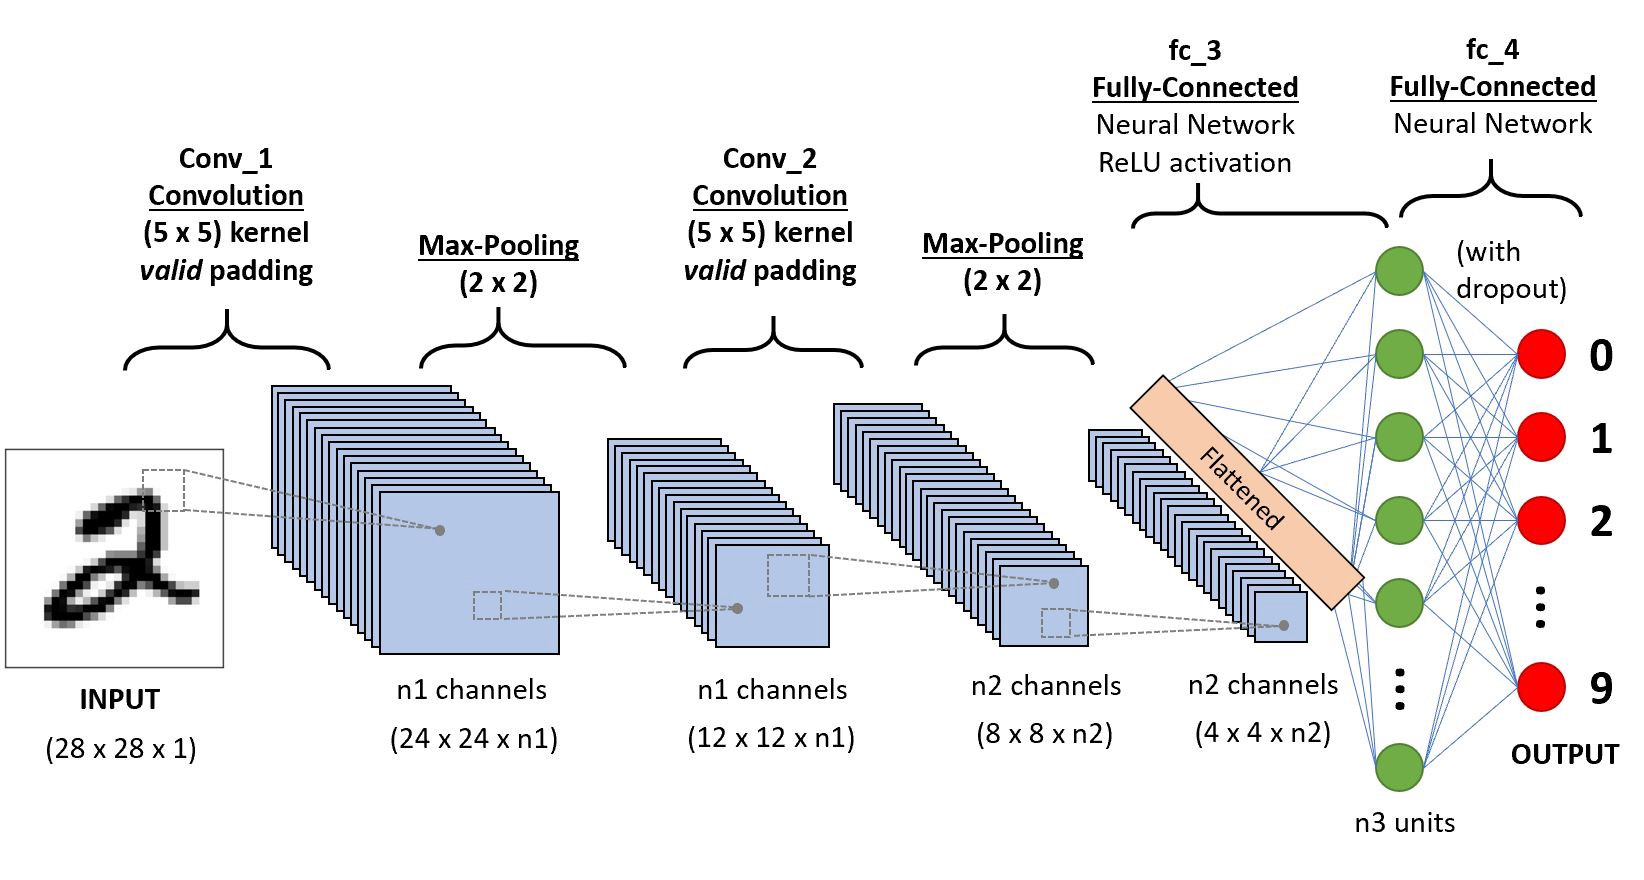

<br>https://ithelp.ithome.com.tw/articles/10285235
<br>https://ithelp.ithome.com.tw/articles/10191820
<br>https://ithelp.ithome.com.tw/articles/10199130
<br>https://ithelp.ithome.com.tw/articles/10266985

In [ ]:
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)

# Convolution Layer 卷積層 : 即是將 "Input" 與 "Filter" 以 numpy nd array 的方式相乘後加總
# - filters : 該卷積層想要使用多少個 filters, 常設 4 的倍數
# - kernel_size : filter 的 shape, 常設奇數邊長的正方形（3*3, 5*5 等）
# - strides : 滑動步長，計算滑動視窗時移動的格數, 默認 (1, 1)
# - padding : 補 0 策略，卷積層取 kernel_size 滑動視窗時，若超越邊界，是選擇
#         放棄這個 output 點（valid）、一律補零（same）、或是不計算超越邊界的 Input 值（causal）
# - activation : 選擇你想使用的激勵函數, 默認 None

# Pooling Layer 池化層 : 用來「壓縮並保留」重要資訊的方法 (將區域內選出最大值 or 計算平均)
# - pool_size : 池化視窗的大小, 常設 2*2
# - strides : 滑動步長，計算滑動視窗時移動的格數, 默認 (1, 1)
# - padding : 補 0 策略，卷積層取 kernel_size 滑動視窗時，若超越邊界，是選擇
#         放棄這個 output 點（valid）、一律補零（same）、或是不計算超越邊界的 Input 值（causal）

# Fully Connected Layer 全連接層 : 將結果平坦化後連接，概念就像是把 2D 的圖片拍扁變成 1D 的數列
# Dense 隱藏層

"""
layers = \
  [# stage 1
   Convolution2D(filters=28, kernel_size=(3, 3), input_shape=(ROWS, COLS, 3), activation='relu', padding='same'),
   Dropout(0.2),
   Convolution2D(filters=28, kernel_size=(3, 3), activation='relu', padding='same'),
   MaxPooling2D(pool_size=(2, 2)),

   # stage 2
   Convolution2D(filters=56, kernel_size=(3, 3), activation='relu', padding='same'),
   Dropout(0.2),
   Convolution2D(filters=56, kernel_size=(3, 3), activation='relu', padding='same'),
   MaxPooling2D(pool_size=(2, 2)),
   
   # stage 3
   Convolution2D(filters=112, kernel_size=(3, 3), activation='relu', padding='same'),
   Dropout(0.2),
   Convolution2D(filters=112, kernel_size=(3, 3), activation='relu', padding='same'),
   MaxPooling2D(pool_size=(2, 2)),

   # stage 4
   Convolution2D(filters=448, kernel_size=(3, 3), activation='relu', padding='same'),
   Dropout(0.2),
   Convolution2D(filters=448, kernel_size=(3, 3), activation='relu', padding='same'),
   MaxPooling2D(pool_size=(2, 2)),

   Flatten(), Dense(896, activation='relu'),
   Dropout(0.3), Dense(448, activation='relu'),
   Dropout(0.3), Dense(62), Activation('softmax')]
"""

layers = \
  [# stage 1
   Convolution2D(filters=32, kernel_size=(3, 3), input_shape=(ROWS, COLS, 3), activation='relu', padding='same'),
   Dropout(0.2),
   Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
   MaxPooling2D(pool_size=(2, 2)),

   # stage 2
   Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
   Dropout(0.2),
   Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
   MaxPooling2D(pool_size=(2, 2)),
   
   # stage 3
   Convolution2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
   Dropout(0.2),
   Convolution2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
   MaxPooling2D(pool_size=(2, 2)),

   # stage 4
   Convolution2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
   Dropout(0.2),
   Convolution2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
   MaxPooling2D(pool_size=(2, 2)),

   Flatten(), Dense(1024, activation='relu'),
   Dropout(0.3), Dense(512, activation='relu'),
   Dropout(0.3), Dense(62), Activation('softmax')]

model = Sequential()
for layer in layers:
    model.add(layer)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(images, labels, epochs=40, batch_size=112, validation_data=(images_test, labels_test))
history = model.fit(datagen.flow(images, labels, batch_size=112), epochs=50, validation_data=(images_test, labels_test), verbose=1)
model.summary()

Epoch 1/50
66/66 [==============================] - 138s 2s/step - loss: 3.8554 - accuracy: 0.0660 - val_loss: 3.7750 - val_accuracy: 0.0494
Epoch 2/50
66/66 [==============================] - 132s 2s/step - loss: 3.7980 - accuracy: 0.0700 - val_loss: 3.7701 - val_accuracy: 0.0494
Epoch 3/50
66/66 [==============================] - 129s 2s/step - loss: 3.8025 - accuracy: 0.0673 - val_loss: 3.7663 - val_accuracy: 0.0753
Epoch 4/50
66/66 [==============================] - 129s 2s/step - loss: 3.7820 - accuracy: 0.0700 - val_loss: 3.7120 - val_accuracy: 0.0753
Epoch 5/50
66/66 [==============================] - 133s 2s/step - loss: 3.6026 - accuracy: 0.1083 - val_loss: 3.1179 - val_accuracy: 0.2390
Epoch 6/50
66/66 [==============================] - 129s 2s/step - loss: 2.9301 - accuracy: 0.2450 - val_loss: 2.2920 - val_accuracy: 0.3818
Epoch 7/50
66/66 [==============================] - 130s 2s/step - loss: 2.2915 - accuracy: 0.3841 - val_loss: 1.6544 - val_accuracy: 0.5481
Epoch 8/50
66

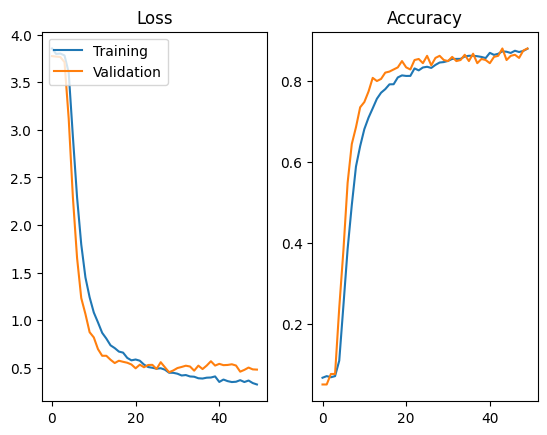

In [ ]:
import matplotlib.pyplot as plt

loss = history.history.get('loss')
acc  = history.history.get('accuracy')
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_accuracy')

plt.figure(0)
plt.subplot(121)
plt.plot(range(len(loss)), loss, label='Training')
plt.plot(range(len(val_loss)), val_loss, label='Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(range(len(acc)), acc, label='Training')
plt.plot(range(len(val_acc)), val_acc ,label='Validation')
plt.title('Accuracy')
plt.show()
plt.close()

In [ ]:
# save the model to disk
filename = 'drive/My Drive/Colab Notebooks/Détecter_des_caractères.sav'
joblib.dump(model, filename)

['drive/My Drive/Colab Notebooks/Détecter_des_caractères.sav']

In [ ]:
# load the model from disk
loaded_model = joblib.load(filename)
# result = loaded_model.evaluate(images_test, labels_test)
# print(result)

In [ ]:
from numpy import argmax

CHARS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
predictions = loaded_model.predict(img_list_resize)
img_list_text = []

for index in range(img_num):
  # imshow(img_list_resize[i])
  text_detected = CHARS[argmax(predictions[index])]
  img_list_text.append(text_detected)
  # print('prediction : ', text_detected)

print('Prediction : ', img_list_text)

1/1 [==============================] - 0s 247ms/step
Prediction :  ['S', 'T', 'A', 'R', 'S', 'C', 'A', 'N', 'l', 'T', 'S', 'H', 'l', 'N', 'E', 'W', 'l', 'T', 'H', 'O', 'U', 'T', 'D', 'A', 'R', 'K', 'N', 'E', 'S', 'S']


5. **Text Reconstruction** : This is the last part of the work and simply consists in putting together all the pieces of the puzzle we have build so far. Just to recap, we have characters with rectangles coordinates from the original image and predictions. What we can do is simply build an other figure plotting the predicted strings in the right positions.
<br>https://matplotlib.org/stable/tutorials/text/text_intro.html

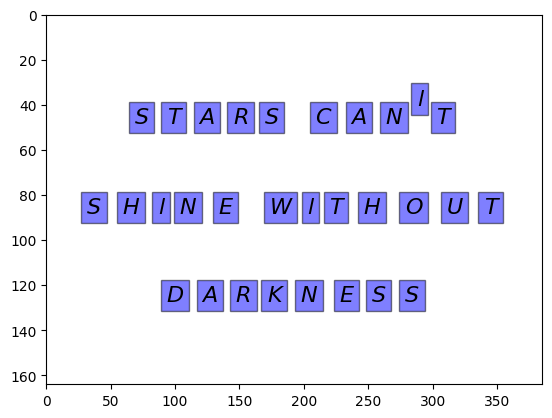

In [ ]:
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot()

# Set both x- and y-axis limits to [0, *] instead of default [0, 1]
ax.axis([0, img_width, img_height, 0])

for index in range(img_num):
  pos_x = int((bounding_boxes_new[index][1] + bounding_boxes_new[index][0]) / 2)
  pos_y = int((bounding_boxes_new[index][3] + bounding_boxes_new[index][2]) / 2)

  ax.text(pos_y, pos_x, img_list_text[index], style='italic', fontsize=16,
          verticalalignment='top', horizontalalignment='center',
          bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 4})

matplotlib.pyplot.show()

## **Test the model.**

<ipython-input-22-5daeccdd0eb5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_tvDenoised = denoise_tv_chambolle(img_gray, weight=0.2, multichannel=True) # Using total variation filter denoising


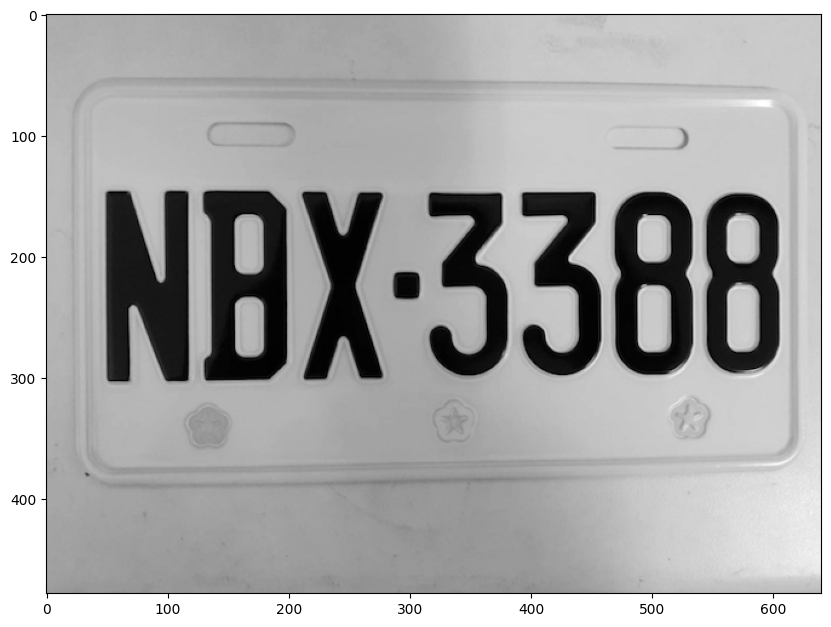

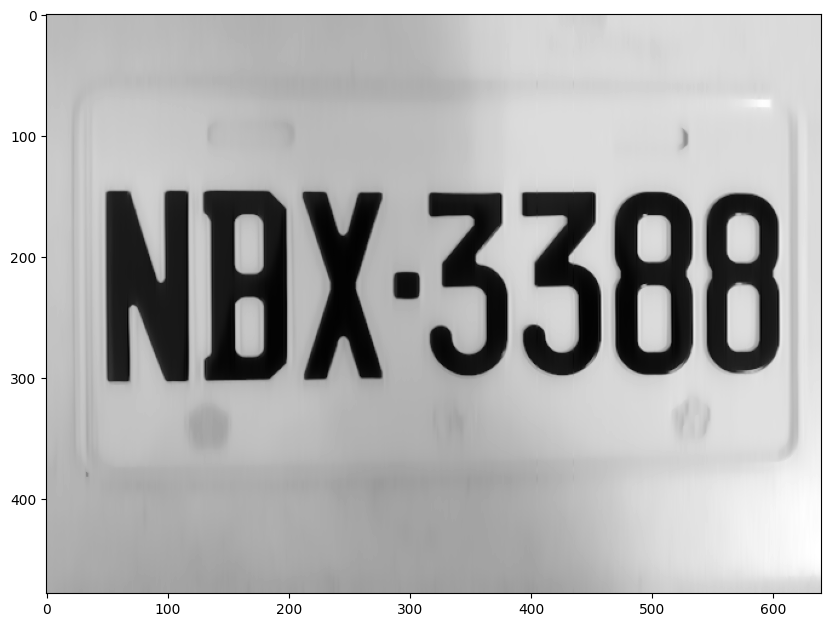

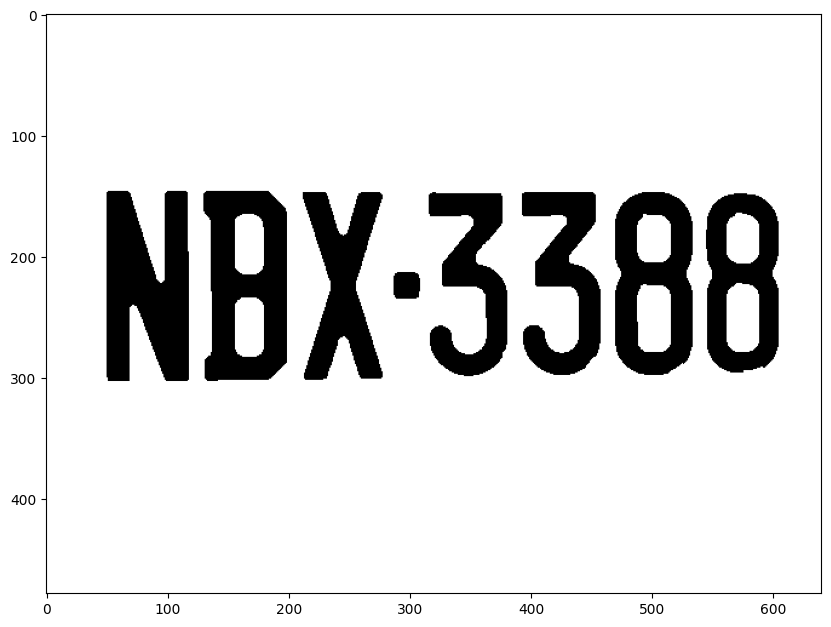

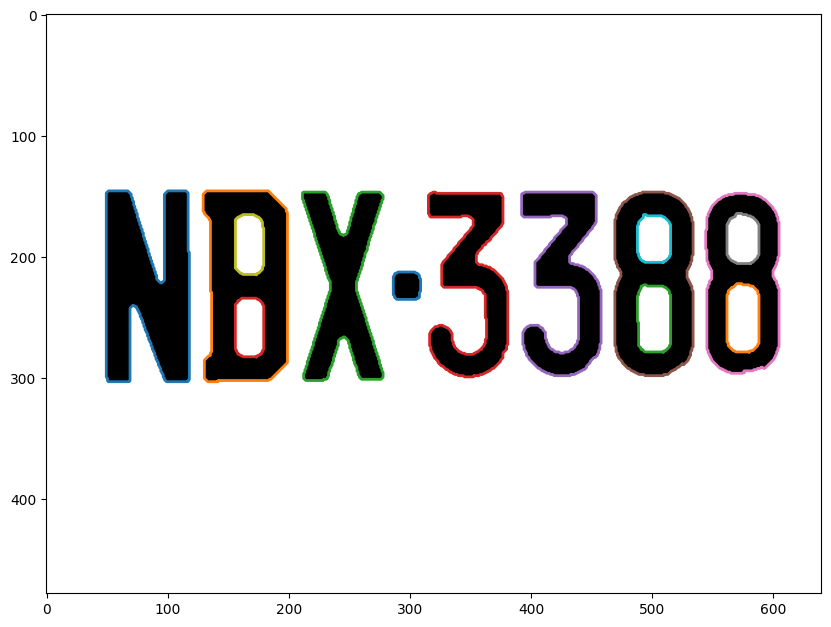

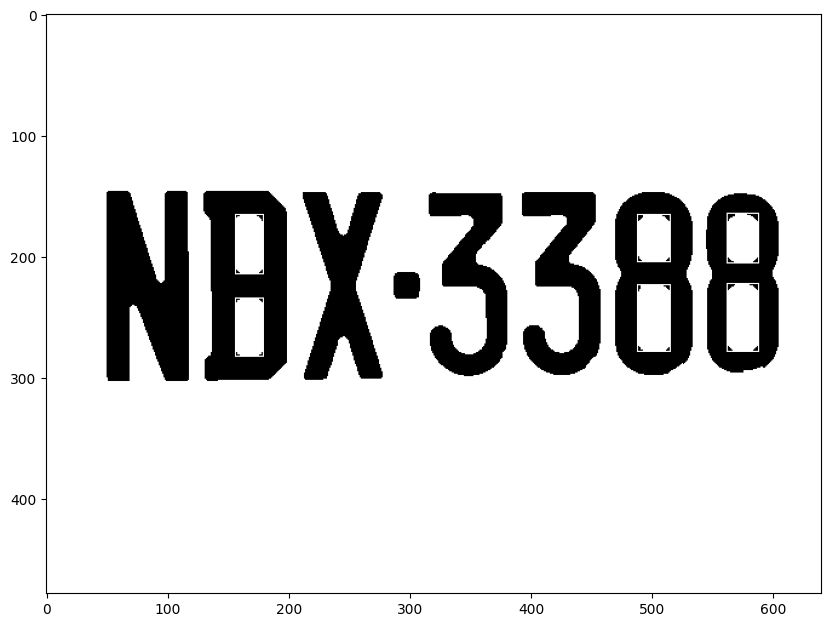

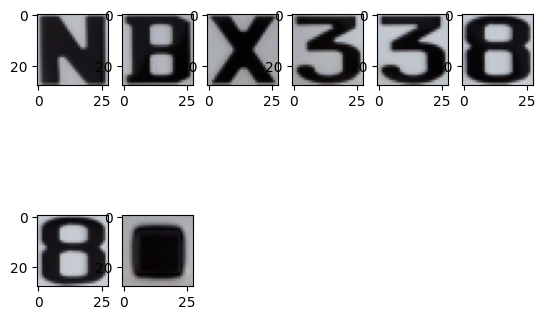

In [ ]:
from skimage.io import imread
from matplotlib.pyplot import figure, imshow

img_gray = imread('drive/My Drive/Colab Notebooks/car01.jpg', as_gray=True) # lecture de l'image
img_rgb = imread('drive/My Drive/Colab Notebooks/car01.jpg', as_gray=False) # lecture de l'image
img_height, img_width = img_gray.shape
figure(figsize=(10, 10)) # visualisation
imshow(img_gray, cmap='gray') # visualisation de l'image image.jpg

img_tvDenoised = denoise_tv_chambolle(img_gray, weight=0.2, multichannel=True) # Using total variation filter denoising
figure(figsize=(10, 10)) # visualisation
imshow(img_tvDenoised, cmap='gray') # visualisation de l'image img_tvDenoised.png

thresh = threshold_otsu(img_tvDenoised)
img_binary = img_tvDenoised > thresh
figure(figsize=(10, 10)) # visualisation
imshow(img_binary, cmap='gray')

# Find contours at a constant value of 0.8
contours = find_contours(img_binary, level=0.8)
# Display the image and plot all contours found
figure(figsize=(10, 10)) # visualisation
for contour in contours:
  plot(contour[:, 1], contour[:, 0], linewidth=2)
imshow(img_binary, cmap='gray')
# matplotlib.pyplot.gca().invert_yaxis()

bounding_boxes = []
img_with_boxes = copy(img_binary)
for contour in contours:
  Xmin = min(contour[:, 0])
  Xmax = max(contour[:, 0])
  Ymin = min(contour[:, 1])
  Ymax = max(contour[:, 1])
  bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
  # print([int(Xmin), int(Xmax), int(Ymin), int(Ymax)])
for box in bounding_boxes:
  # [Xmin, Xmax, Ymin, Ymax]
  r = [box[0], box[1], box[1], box[0], box[0]]
  c = [box[3], box[3], box[2], box[2], box[3]]
  rr, cc = polygon_perimeter(r, c, img_with_boxes.shape)
  img_with_boxes[rr, cc] = 1 # set color white
# with_boxes = invert(with_boxes)
figure(figsize=(10, 10)) # visualisation
imshow(img_with_boxes, cmap="gray")

# delete one bounding box that are smaller than another bounding box
bounding_boxes_new = bounding_boxes.copy()
for box_i in bounding_boxes:
  i_Xmin = box_i[0]
  i_Xmax = box_i[1]
  i_Ymin = box_i[2]
  i_Ymax = box_i[3]
  for box_j in bounding_boxes:
    j_Xmin = box_j[0]
    j_Xmax = box_j[1]
    j_Ymin = box_j[2]
    j_Ymax = box_j[3]
    if (j_Xmin > i_Xmin) and (j_Xmax < i_Xmax) and (j_Ymin > i_Ymin) and (j_Ymax < i_Ymax):
      bounding_boxes_new.remove([j_Xmin, j_Xmax, j_Ymin, j_Ymax])
# print('Before : ', len(bounding_boxes), 'After : ', len(bounding_boxes_new))

img_num = len(bounding_boxes_new)
ROWS = 28 # 18
COLS = 28 # 12
fig = matplotlib.pyplot.figure()
img_list_resize = zeros(shape=(img_num, ROWS, COLS, 3))
for box in range(img_num):
  # nb_subplot = ceil(math.sqrt(len(bounding_boxes))) # if we have 38 images, we output 7*7 subplot
  # ax = fig.add_subplot(nb_subplot, nb_subplot, box+1)
  nb_subplot = ceil(img_num/6)
  ax = fig.add_subplot(nb_subplot, 6, box+1)
  # bias_width = 36 - (ceil(bounding_boxes[box][1]) - floor(bounding_boxes[box][0]))
  # bias_heigh = 24 - (ceil(bounding_boxes[box][3]) - floor(bounding_boxes[box][2]))
  # mean_bw = bias_width / 2
  # mean_bh = bias_heigh / 2
  add_edge = 3
  # img_binary[rect_bottom:rect_top, rect_left:rect_right]
  img_patch = img_rgb[floor(bounding_boxes_new[box][0]-add_edge):ceil(bounding_boxes_new[box][1]+add_edge),
                      floor(bounding_boxes_new[box][2]-add_edge):ceil(bounding_boxes_new[box][3]+add_edge)]
  img_resize = resize(img_patch, (ROWS, COLS, 3))
  img_list_resize[box] = img_resize
  ax.imshow(img_resize, cmap="gray")

1/1 [==============================] - 0s 77ms/step
Prediction :  ['N', 'B', 'X', '3', '3', '8', '8', 'I']


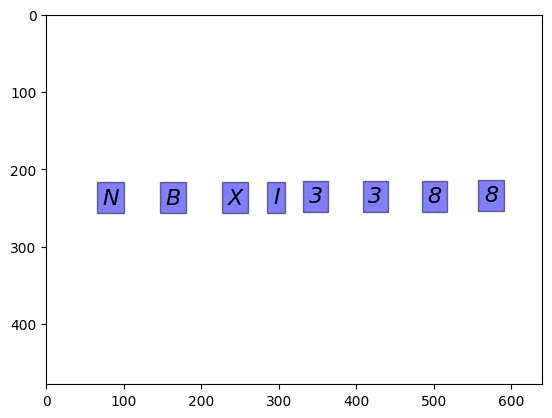

In [ ]:
CHARS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
predictions = loaded_model.predict(img_list_resize)
img_list_text = []
for index in range(img_num):
  # imshow(img_list_resize[i])
  text_detected = CHARS[argmax(predictions[index])]
  img_list_text.append(text_detected)
  # print('prediction : ', text_detected)
print('Prediction : ', img_list_text)

fig = matplotlib.pyplot.figure()
ax = fig.add_subplot()
# Set both x- and y-axis limits to [0, *] instead of default [0, 1]
ax.axis([0, img_width, img_height, 0])
for index in range(img_num):
  pos_x = int((bounding_boxes_new[index][1] + bounding_boxes_new[index][0]) / 2)
  pos_y = int((bounding_boxes_new[index][3] + bounding_boxes_new[index][2]) / 2)

  ax.text(pos_y, pos_x, img_list_text[index], style='italic', fontsize=16,
          verticalalignment='top', horizontalalignment='center',
          bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 4})
matplotlib.pyplot.show()

<ipython-input-24-f4e451c259ba>:7: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_tvDenoised = denoise_tv_chambolle(img_gray, weight=0.2, multichannel=True) # Using total variation filter denoising


ValueError: ignored

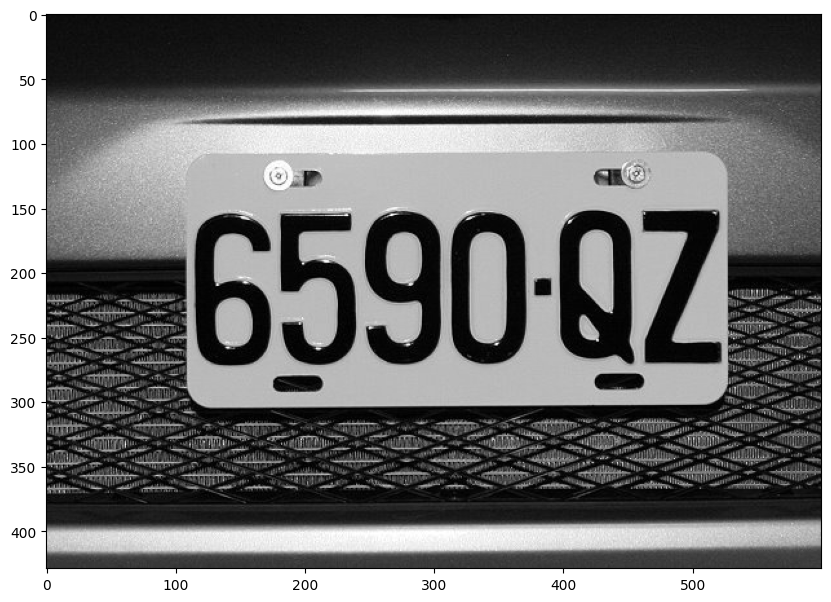

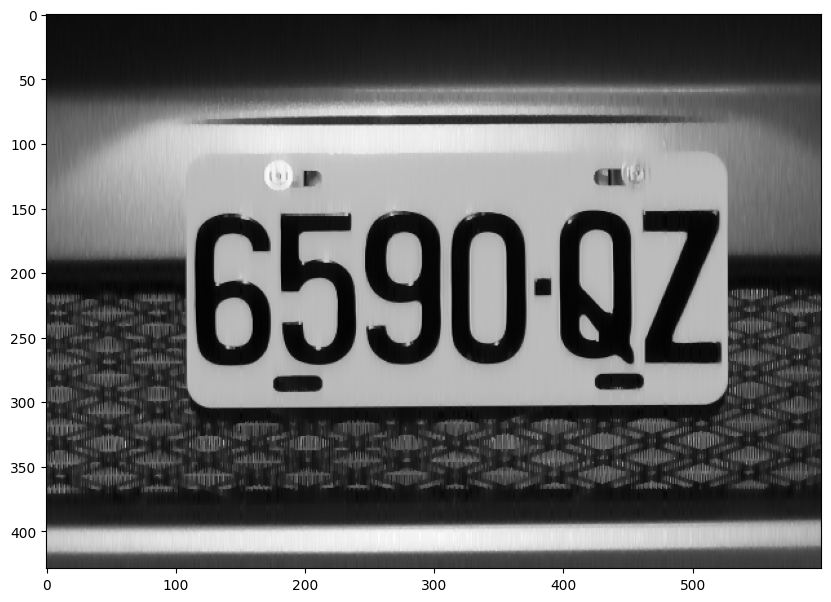

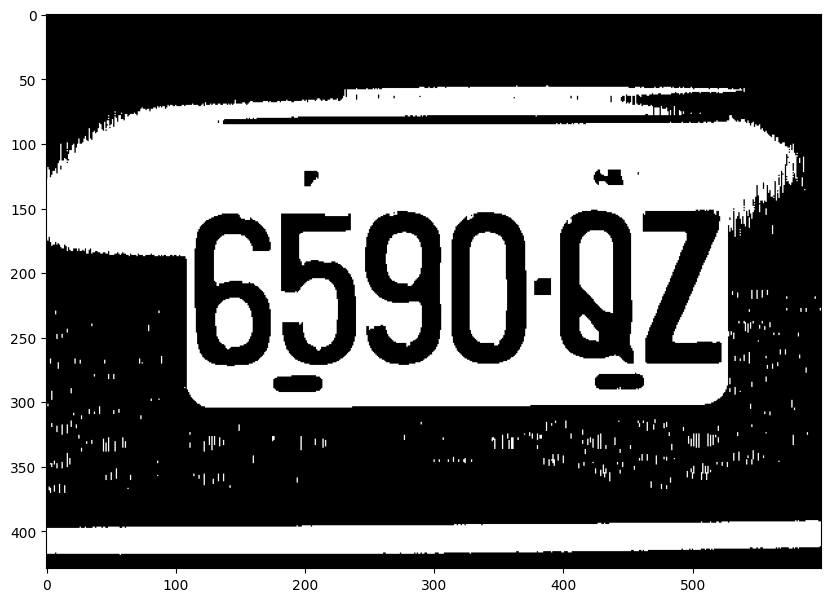

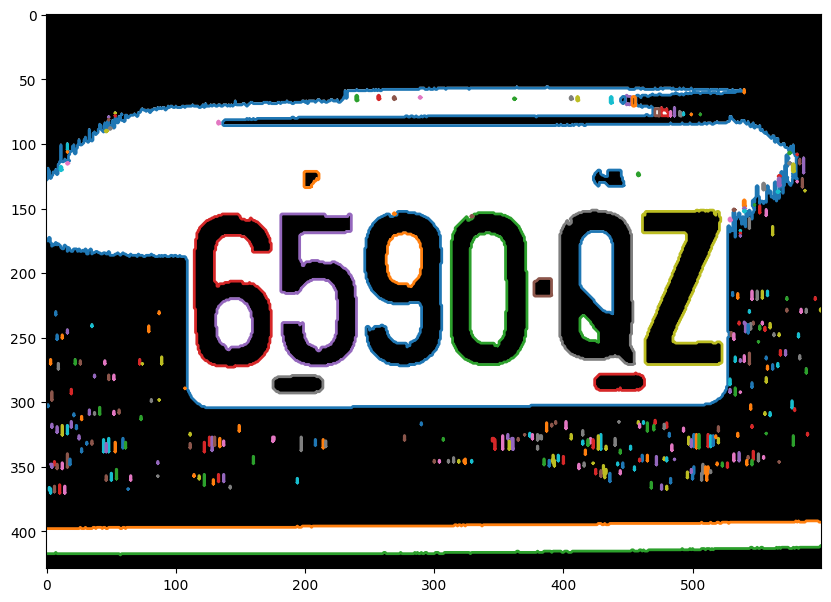

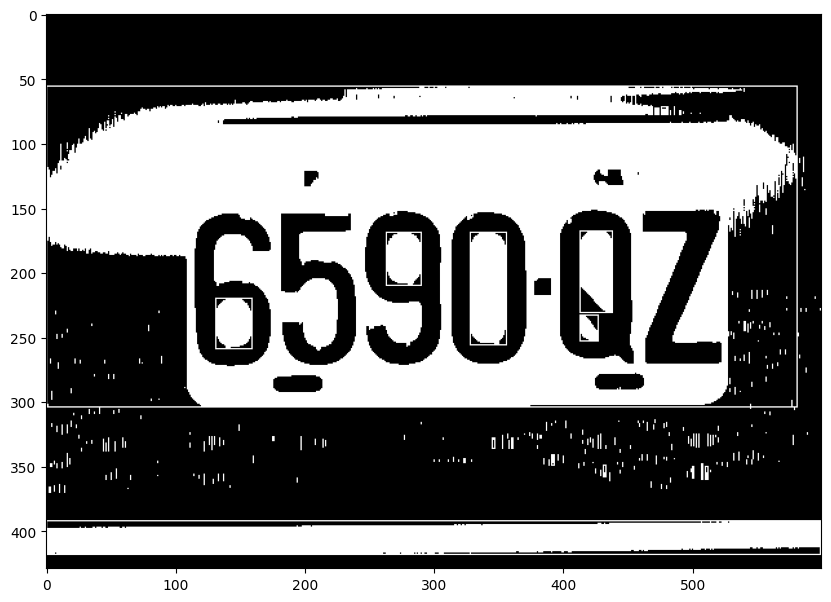

In [ ]:
img_gray = imread('drive/My Drive/Colab Notebooks/car04.jpg', as_gray=True) # lecture de l'image
img_rgb = imread('drive/My Drive/Colab Notebooks/car04.jpg', as_gray=False) # lecture de l'image
img_height, img_width = img_gray.shape
figure(figsize=(10, 10)) # visualisation
imshow(img_gray, cmap='gray') # visualisation de l'image image.jpg

img_tvDenoised = denoise_tv_chambolle(img_gray, weight=0.2, multichannel=True) # Using total variation filter denoising
figure(figsize=(10, 10)) # visualisation
imshow(img_tvDenoised, cmap='gray') # visualisation de l'image img_tvDenoised.png

thresh = threshold_otsu(img_tvDenoised)
img_binary = img_tvDenoised > thresh
figure(figsize=(10, 10)) # visualisation
imshow(img_binary, cmap='gray')

# Find contours at a constant value of 0.8
contours = find_contours(img_binary, level=0.8)
# Display the image and plot all contours found
figure(figsize=(10, 10)) # visualisation
for contour in contours:
  plot(contour[:, 1], contour[:, 0], linewidth=2)
imshow(img_binary, cmap='gray')
# matplotlib.pyplot.gca().invert_yaxis()

bounding_boxes = []
img_with_boxes = copy(img_binary)
for contour in contours:
  Xmin = min(contour[:, 0])
  Xmax = max(contour[:, 0])
  Ymin = min(contour[:, 1])
  Ymax = max(contour[:, 1])
  bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
  # print([int(Xmin), int(Xmax), int(Ymin), int(Ymax)])
for box in bounding_boxes:
  # [Xmin, Xmax, Ymin, Ymax]
  r = [box[0], box[1], box[1], box[0], box[0]]
  c = [box[3], box[3], box[2], box[2], box[3]]
  rr, cc = polygon_perimeter(r, c, img_with_boxes.shape)
  img_with_boxes[rr, cc] = 1 # set color white
# with_boxes = invert(with_boxes)
figure(figsize=(10, 10)) # visualisation
imshow(img_with_boxes, cmap="gray")

# delete one bounding box that are smaller than another bounding box
bounding_boxes_new = bounding_boxes.copy()
for box_i in bounding_boxes:
  i_Xmin = box_i[0]
  i_Xmax = box_i[1]
  i_Ymin = box_i[2]
  i_Ymax = box_i[3]
  for box_j in bounding_boxes:
    j_Xmin = box_j[0]
    j_Xmax = box_j[1]
    j_Ymin = box_j[2]
    j_Ymax = box_j[3]
    if (j_Xmin > i_Xmin) and (j_Xmax < i_Xmax) and (j_Ymin > i_Ymin) and (j_Ymax < i_Ymax):
      bounding_boxes_new.remove([j_Xmin, j_Xmax, j_Ymin, j_Ymax])
# print('Before : ', len(bounding_boxes), 'After : ', len(bounding_boxes_new))

img_num = len(bounding_boxes_new)
ROWS = 28 # 18
COLS = 28 # 12
fig = matplotlib.pyplot.figure()
img_list_resize = zeros(shape=(img_num, ROWS, COLS, 3))
for box in range(img_num):
  # nb_subplot = ceil(math.sqrt(len(bounding_boxes))) # if we have 38 images, we output 7*7 subplot
  # ax = fig.add_subplot(nb_subplot, nb_subplot, box+1)
  nb_subplot = ceil(img_num/6)
  ax = fig.add_subplot(nb_subplot, 6, box+1)
  # bias_width = 36 - (ceil(bounding_boxes[box][1]) - floor(bounding_boxes[box][0]))
  # bias_heigh = 24 - (ceil(bounding_boxes[box][3]) - floor(bounding_boxes[box][2]))
  # mean_bw = bias_width / 2
  # mean_bh = bias_heigh / 2
  add_edge = 3
  # img_binary[rect_bottom:rect_top, rect_left:rect_right]
  img_patch = img_rgb[floor(bounding_boxes_new[box][0]-add_edge):ceil(bounding_boxes_new[box][1]+add_edge),
                      floor(bounding_boxes_new[box][2]-add_edge):ceil(bounding_boxes_new[box][3]+add_edge)]
  img_resize = resize(img_patch, (ROWS, COLS, 3))
  img_list_resize[box] = img_resize
  ax.imshow(img_resize, cmap="gray")

In [ ]:
CHARS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
predictions = loaded_model.predict(img_list_resize)
img_list_text = []
for index in range(img_num):
  # imshow(img_list_resize[i])
  text_detected = CHARS[argmax(predictions[index])]
  img_list_text.append(text_detected)
  # print('prediction : ', text_detected)
print('Prediction : ', img_list_text)

fig = matplotlib.pyplot.figure()
ax = fig.add_subplot()
# Set both x- and y-axis limits to [0, *] instead of default [0, 1]
ax.axis([0, img_width, img_height, 0])
for index in range(img_num):
  pos_x = int((bounding_boxes_new[index][1] + bounding_boxes_new[index][0]) / 2)
  pos_y = int((bounding_boxes_new[index][3] + bounding_boxes_new[index][2]) / 2)

  ax.text(pos_y, pos_x, img_list_text[index], style='italic', fontsize=16,
          verticalalignment='top', horizontalalignment='center',
          bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 4})
matplotlib.pyplot.show()